In [3]:
import xarray as xr
import fsspec
import os
from vcm.select import RegionOfInterest

kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
kg_m2_to_mm  = 1000. / 997.0

import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
import fv3viz
import cftime
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import timedelta
import seaborn as sns
import vcm


slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()

figsize=(12,4)
col_wrap = 2
rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}


In [36]:
import fv3viz
fv3viz.use_colorblind_friendly_style()

In [46]:
from cycler import cycler
import matplotlib as mpl

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colorlist = [default_colors[-5], 'black', ] + default_colors
linestyle_list = ["--","--" ] + ["-" for v in default_colors]


cmap = mpl.colors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors, linestyle=linestyle_list) #or simply color=colorlist

cmap_no_verif = mpl.colors.ListedColormap(colorlist[1:])
custom_cycler_no_verif = cycler(color=cmap_no_verif.colors, linestyle=linestyle_list[1:]) #or simply color=colorlist


In [49]:
experiments = {
    "Baseline": "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed",
    "NN seed 0 (1 yr, PIRE SSTs)": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-06-10/updated-rad-fluxes-seed-0-no-tapering/",
    "NN seed 0 (5 yr, climat. SSTs)": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-06-16/multiyear-climat-sst-updated-rad-seed-0",
}

In [50]:
sfc_vars = [
    "DLWRFsfc",
    "DSWRFsfc",
    "USWRFsfc",]

In [51]:
labels, diags = [], []
for experiment, prog_run in experiments.items():
    diags.append(intake.open_zarr(os.path.join(prog_run, "fv3gfs_run", "diags.zarr")).to_dask()[['total_precipitation_rate', 'water_vapor_path']])
    labels.append(experiment)
    
ds = xr.concat(diags, dim=pd.Index(labels, name="experiment")) \
    

In [52]:
verif_dyn = catalog["2020_1yr_pire_dyn"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"})
verif_physics = catalog["2020_1yr_pire_physics"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"}) 

In [53]:
common_coords = {
    "x": grid.x.values,
    "y": grid.y.values,
    "tile": grid.tile.values
}
grid = grid.assign_coords(common_coords)
diags = [ds_.assign_coords(common_coords) for ds_ in diags]
verif_dyn = verif_dyn.assign_coords(common_coords)
verif_physics = verif_physics.assign_coords(common_coords)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


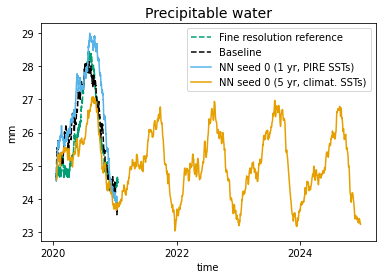

In [54]:

fig = plt.figure()
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

verif_pwat = vcm.weighted_average(verif_dyn["PWAT"] * kg_m2_to_mm, grid.area)
ax.plot(verif_pwat.time.values, verif_pwat.values, label="Fine resolution reference")

for label, ds_ in zip(labels, diags):
    pwat = vcm.weighted_average(ds_["water_vapor_path"].drop_vars(["tile", "x", "y"]), grid.drop_vars(["tile", "x", "y"]).area) * kg_m2_to_mm
    ax.plot(pwat.time, pwat.values, label=label)
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("mm")
ax.set_title("Precipitable water", fontsize=14)


plt.savefig("figures/pdf/prognostic_multiyr_pwat.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_multiyr_pwat.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_multiyr_pwat.eps", format="eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


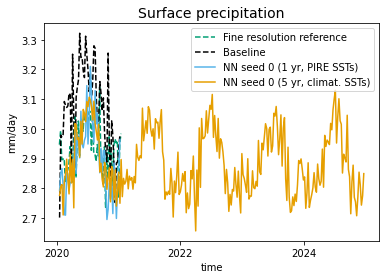

In [55]:

fig = plt.figure()
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

verif_precip = vcm.weighted_average(verif_physics["PRATEsfc_coarse"] * kg_m2s_to_mm_day, grid.area) \
    .resample(time="7D").mean()
ax.plot(verif_precip.time.values, verif_precip.values, label="Fine resolution reference")

for label, ds_ in zip(labels, diags):
    precip = (
        vcm.weighted_average(ds_["total_precipitation_rate"], grid.area) * kg_m2s_to_mm_day
    ).resample(time="7D").mean()
    ax.plot(precip.time, precip.values, label=label)
ax.legend(loc='upper right')
ax.set_xlabel("time")
ax.set_ylabel("mm/day")
ax.set_title("Surface precipitation", fontsize=14)

plt.savefig("figures/pdf/prognostic_multiyr_precip.pdf", dpi=150, bbox_inches='tight')
plt.savefig("figures/png/prognostic_multiyr_precip.png", dpi=150, bbox_inches='tight')
plt.savefig("figures/eps/prognostic_multiyr_precip.eps", format="eps", bbox_inches='tight')

In [63]:
def open_zarr(url: str):
    cachedir = "/tmp/files"
    print(f"Opening {url} with caching at {cachedir}.")
    return xr.open_zarr(
        "filecache::" + url, storage_options={"filecache": {"cache_storage": cachedir}},
         consolidated=True
    )


In [64]:
ds__=open_zarr("gs://vcm-ml-scratch/test-end-to-end-integration/2022-07-22/1aa8e8b-ddba-train-diags-prog/fv3gfs_run/sfc_dt_atmos.zarr")

Opening gs://vcm-ml-scratch/test-end-to-end-integration/2022-07-22/1aa8e8b-ddba-train-diags-prog/fv3gfs_run/sfc_dt_atmos.zarr with caching at /tmp/files.


In [65]:
ds__

<xarray.Dataset>
Dimensions:   (tile: 6, time: 32, grid_yt: 48, grid_xt: 48, grid_x: 49, grid_y: 49)
Coordinates:
  * grid_x    (grid_x) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * grid_xt   (grid_xt) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
  * grid_y    (grid_y) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * grid_yt   (grid_yt) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
  * time      (time) object 2016-08-01 00:30:00 ... 2016-08-01 08:15:00
Dimensions without coordinates: tile
Data variables: (12/18)
    CPRATsfc  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    DLWRFsfc  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    DSWRFsfc  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    DSWRFtoa  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    LHTFLsfc  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    PRATEsfc  (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    ...        ...
    lat       (tile, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    latb      (tile, grid_y, grid_x) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>
    lon       (tile, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    lonb      (tile, grid_y, grid_x) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>
    uflx      (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    vflx      (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>

In [150]:
import math
from toolz import partition_all
limit_mb = 25

# ds size 23.28608 mb
nsplit = math.ceil((ds__.nbytes/1e6)/limit_mb)
x=ds__.data_vars
elems = partition_all(max(len(x)//nsplit, 1) , x)
x = [ds__[list(el)] for el in  elems]
print(len(x))

1


In [153]:
9//4

2

In [143]:
x = [ds__[list(el)] for el in  elems]

In [147]:
x[1]

<xarray.Dataset>
Dimensions:  (tile: 6, grid_yt: 48, grid_xt: 48, grid_y: 49, grid_x: 49, time: 32)
Coordinates:
  * grid_x   (grid_x) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * grid_xt  (grid_xt) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
  * grid_y   (grid_y) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0 49.0
  * grid_yt  (grid_yt) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
  * time     (time) object 2016-08-01 00:30:00 ... 2016-08-01 08:15:00
Dimensions without coordinates: tile
Data variables:
    lat      (tile, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    latb     (tile, grid_y, grid_x) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>
    lon      (tile, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    lonb     (tile, grid_y, grid_x) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>
    uflx     (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>
    vflx     (tile, time, grid_yt, grid_xt) float32 dask.array<chunksize=(6, 16, 48, 48), meta=np.ndarray>

In [136]:
len(x)//nsplit

0

In [117]:
len(ds__.data_vars)

18

In [122]:
os.getenv("PATH") or 1

'/home/AnnaK/.local/bin:/home/AnnaK/miniconda3/bin:/home/AnnaK/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/AnnaK/miniconda3/bin'